In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#path for saving the trained model
model_state_save_file = "new_big_data_89_2_acc_mod_pytorch.pth"
model_save_file = "big_data_89_2_acc_mod_pytorch_fullmodelsave.pt"

In [7]:
#Loading of train and validation/test files
xtrain = np.load("data/xtrain.npy", mmap_mode='r')
ytrain = np.load("data/ytrain.npy", mmap_mode='r')

xtest = np.load("data/xtest.npy", mmap_mode='r')
ytest = np.load("data/ytest.npy", mmap_mode='r')

In [10]:
#get an example for determining shape
newex = xtrain[0]
newex = np.array(newex)
print(newex.shape)

In [13]:
# Define hyperparameters
batch_size = 256
epochs = 19
num_classes = 3

In [14]:
#setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
#model specification
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.LazyConv1d(256, kernel_size=2)
        self.conv2 = nn.LazyConv1d(128, kernel_size=2)
        self.conv3 = nn.LazyConv1d(128, kernel_size=2)

        self.avg_pool = nn.AvgPool1d(kernel_size=2)

        self.dropout = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)

        self.flatten = nn.Flatten()

        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(128)
        self.fc3 = nn.LazyLinear(num_classes)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #correct transposition of input matrix
        x = torch.transpose(x, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.avg_pool(x)
        x = self.dropout(x)
        x = self.relu(self.conv3(x))
        x = self.avg_pool(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)
        #x = self.sigmoid(x)
        return x

In [16]:
# initialize the model
model = ConvNet(num_classes, newex.shape[1])
#send model to device
model = model.to(device)
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

j:\Anaconda3\envs\newest_pytorch\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
# Training loop
for epoch in range(epochs):
    model.train()
    for i in range(0, len(xtrain), batch_size):


        inputs = xtrain[i:i+batch_size]
        labels = ytrain[i:i+batch_size]


        inputs = np.array(inputs, dtype=float)
        labels= np.array(labels, dtype=int)

        inputs = torch.from_numpy(inputs)
        labels = torch.from_numpy(labels)
        inputs = inputs.float()
        labels = labels.long()

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

#save the model
torch.save(model.state_dict(), model_state_save_file)
torch.save(model, model_save_file)

Epoch 1/19, Loss: 0.3425074815750122
Epoch 2/19, Loss: 0.29089534282684326
Epoch 3/19, Loss: 0.3100954294204712
Epoch 4/19, Loss: 0.3055943548679352
Epoch 5/19, Loss: 0.23222194612026215
Epoch 6/19, Loss: 0.2589704096317291
Epoch 7/19, Loss: 0.22863605618476868
Epoch 8/19, Loss: 0.14609144628047943
Epoch 9/19, Loss: 0.1672641485929489
Epoch 10/19, Loss: 0.19531536102294922
Epoch 11/19, Loss: 0.09945584088563919
Epoch 12/19, Loss: 0.15188229084014893
Epoch 13/19, Loss: 0.19550688564777374
Epoch 14/19, Loss: 0.13884283602237701
Epoch 15/19, Loss: 0.11647310853004456
Epoch 16/19, Loss: 0.11412996798753738
Epoch 17/19, Loss: 0.10274356603622437
Epoch 18/19, Loss: 0.15373653173446655
Epoch 19/19, Loss: 0.07324568182229996


In [20]:
#evaluate the model
model.eval()
test_loss = 0
correct = 0
total = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for i in range(0, len(xtest), batch_size):

        inputs = xtest[i:i+batch_size]
        labels = ytest[i:i+batch_size]

        inputs = np.array(inputs, dtype=float)
        labels= np.array(labels, dtype=int)

        inputs = torch.from_numpy(inputs)
        labels = torch.from_numpy(labels)
        inputs = inputs.float()
        labels = labels.long()

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())


avg_test_loss = test_loss / len(xtest)
accuracy = 100 * correct / total
print(f"Average Test Loss: {avg_test_loss}, Accuracy: {accuracy}%")

Average Test Loss: 0.0016087270180384318, Accuracy: 86.28%


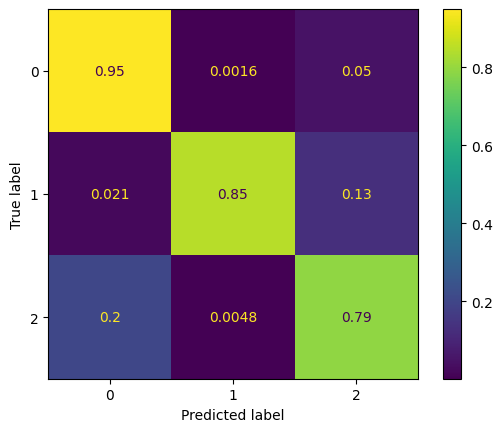

In [35]:
#evaluation: confusion matrix
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, normalize="true")

In [36]:
#another way to plot the confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, classes, normalize=True, title="confusion matrix"):

    #confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    #normalization
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    #plotting using sns
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

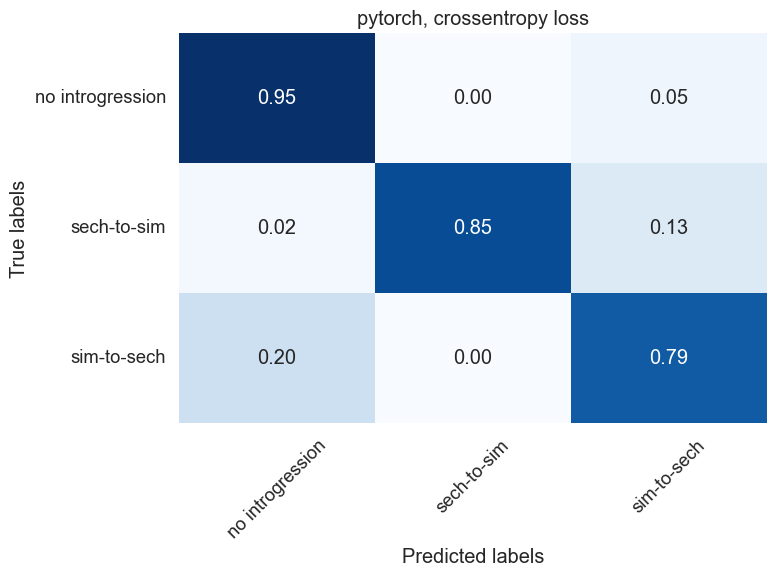

In [38]:
plot_confusion_matrix(true_labels, predicted_labels, classes=['no introgression', 'sech-to-sim', 'sim-to-sech'], title="pytorch, crossentropy loss")